In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn.functional import pad
from torch.utils.data import DataLoader
from torch.jit import load

from rtid.datasets.dataset import DatasetTPC

In [18]:
dataset = DatasetTPC('/data/yhuang2/sphenix/auau/highest_framedata_3d/outer',
                     split = 'test',
                     dimension = 2,
                     axis_order = ('layer', 'azimuth', 'beam'))
batch_size = 1
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

load Au + Au TPC data in ('layer', 'azimuth', 'beam')


## Convolution Neural Networks

In [33]:
ROOT = Path('/home/yhuang2/PROJs/rtid/rtid/ae2d/')
ae_type = 'cae'
num_decoder_layers = 5
checkpoints = ROOT/ae_type/f'checkpoints_decoder-{num_decoder_layers}'
enc_pth = checkpoints/'enc_last.pth'
dec_pth = checkpoints/'dec_last.pth'
enc_pth.exists()

encoder = load(enc_pth).cuda()
decoder = load(dec_pth).cuda()
_ = encoder.eval()
_ = decoder.eval()
print(checkpoints)

/home/yhuang2/PROJs/rtid/rtid/ae2d/cae/checkpoints_decoder-5


In [34]:
# pd.set_option("display.precision", 3)
# for l in [3, 4, 5]:
#     checkpoints = ROOT/'cae'/f'checkpoints_decoder-{l}'
#     df = pd.read_csv(checkpoints/'mse_test.csv', header = None, names = ['mse'])
#     print(l)
#     # print(df.head())
#     print(df.describe().loc[['mean'], :])

In [35]:
loss_fn = nn.MSELoss()
mse = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = batch.cuda()
        comp = encoder(pad(batch, (0, 7)))
        decomp = decoder(comp)[..., :-7]
        loss = loss_fn(decomp, batch).item()
        mse.append(loss)

        # np.savez_compressed(checkpoints/'sample',
        #                     rec = decomp.squeeze().detach().cpu().numpy(),
        #                     raw = batch.squeeze().detach().cpu().numpy())
        # break


  0%|                                                                                                                                                                                                                                                                                                                                                              | 0/6288 [00:00<?, ?it/s]


In [19]:
mean = np.mean(mse)
std = np.mean(mse)
print(mean, std)
np.savetxt(checkpoints/'mse_test.csv', mse, newline = '\n', fmt = '%.3f')

199.69633534785748 199.69633534785748


In [6]:
# fig, ax = plt.subplots(1, 1)
# sns.histplot(mse, ax = ax, bins = 75)
# ax.axvline(mean, color='orange', label=f'mean={mean:.3f}')
# ax.set_xlim(0, 700)
# ax.legend()
# ax.set_title(f'{ae_type.upper()}, decoder layers = {num_decoder_layers}')
# fig.savefig(f'results/{ae_type}_decoder-{num_decoder_layers}.png', dpi = 200, bbox_inches = 'tight', transparent = True)

## Bicephalous Convolution Neural Networks

In [48]:
ROOT = Path('/home/yhuang2/PROJs/rtid/rtid/ae2d/')
ae_type = 'bcae'
num_decoder_layers = 5
trans_status = 'trans'
checkpoints = ROOT/ae_type/f'checkpoints_decoder-{num_decoder_layers}_{trans_status}'
enc_pth = checkpoints/'enc_last.pth'
dec_pth = checkpoints/'dec_last.pth'
enc_pth.exists()

encoder = load(enc_pth).cuda()
decoder = load(dec_pth).cuda()
_ = encoder.eval()
_ = decoder.eval()
print(checkpoints)

/home/yhuang2/PROJs/rtid/rtid/ae2d/bcae/checkpoints_decoder-5_trans


In [49]:
# from itertools import product
# pd.set_option("display.precision", 3)
# for l, t in product([5, 6], ['trans', 'notrans']):
#     checkpoints = ROOT/ae_type/f'checkpoints_decoder-{l}_{t}'
#     df = pd.read_csv(checkpoints/'stat_test.csv')
#     print(l, t)
#     print(df.describe().loc[['mean'], :])

In [50]:
threshold = .5
loss_fn = nn.MSELoss()
mag, mse, precision, recall = [], [], [], []

with torch.no_grad():
    pbar = tqdm(f'{ae_type}, decoder = {num_decoder_layers}', total = len(dataloader))
    for batch in dataloader:
        batch = batch.cuda()
        mag.append(torch.pow(batch, 2).mean().item())
        
        comp = encoder(pad(batch, (0, 7)))
        clf, reg = decoder(comp)
        
        clf = clf[..., :-7]
        reg = reg[..., :-7]

        if trans_status == 'trans':
            reg = torch.clamp(reg, max = 5.08)
            reg = torch.exp(reg) * 6 + 64
            
        mask = clf > threshold
        decomp = reg * mask
        loss = loss_fn(decomp, batch).item()
        mse.append(loss)
        
        pos = mask.sum()
        tag = batch > 0
        true = tag.sum()
        true_pos = (mask * tag).sum()
        precision.append((true_pos / pos).item())
        recall.append((true_pos / true).item())
        
        pbar.update()
        pbar.set_postfix({'mag': mag[-1],
                          'mse': mse[-1], 
                          'precision': precision[-1], 
                          'recall': recall[-1]})

        # np.savez_compressed(checkpoints/'sample',
        #                     rec = decomp.squeeze().detach().cpu().numpy(),
        #                     raw = batch.squeeze().detach().cpu().numpy())
        # break


  0%|                                                                                                                                                                                                                                                                                              | 1/6288 [00:17<30:20:28, 17.37s/it, mag=2.24e+3, mse=404, precision=0.853, recall=0.849]

  0%|                                                                                                                                                                                                                                                                                                 | 1/6288 [00:00<09:20, 11.22it/s, mag=2.24e+3, mse=424, precision=0.856, recall=0.837]

In [5]:
df = pd.DataFrame(data = {'mag': mag, 'mse': mse, 'precision': precision, 'recall': recall})
df['mse_mag_ratio'] = df['mse'] / df['mag']
df.to_csv(checkpoints/'stat_test.csv', index = False)
df.describe()

,mag,mse,precision,recall,mse_mag_ratio
count,6288.000000,6288.000000,6288.000000,6288.000000,6288.000000
mean,1577.441668,221.037359,0.882449,0.871535,0.134907
std,570.353486,115.606810,0.019086,0.020822,0.026974
min,425.111694,46.127678,0.809928,0.792184,0.052177
25%,1165.262604,139.759270,0.870245,0.858256,0.115845
50%,1477.706482,190.866348,0.885445,0.874961,0.132299
75%,1887.006378,272.281876,0.896783,0.887093,0.151675
max,4925.432129,1008.299255,0.924633,0.915881,0.247252


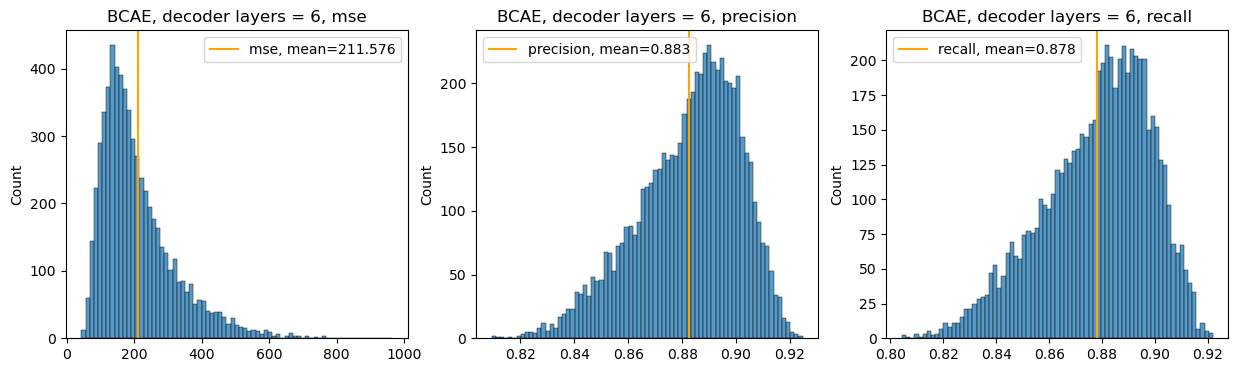

In [9]:
# width, height = 5, 4
# fig, axes = plt.subplots(1, 3, figsize=(3 * width, height))

# for col, ax in zip(['mse', 'precision', 'recall'], axes):
#     sns.histplot(df[col].values, ax = ax, bins = 75)
#     mean = df[col].mean()
#     ax.axvline(mean, color='orange', label=f'{col}, mean={mean:.3f}')
#     # ax.set_xlim(0, 700)
#     ax.legend()
#     ax.set_title(f'{ae_type.upper()}, decoder layers = {num_decoder_layers}, {col}')

# fig.savefig(f'results/{ae_type}_decoder-{num_decoder_layers}.png', dpi = 600, bbox_inches = 'tight', transparent = True)

## Visualization

In [73]:
import matplotlib.pyplot as plt

checkpoints_decoder-6_notrans
checkpoints_decoder-5_notrans
checkpoints_decoder-6_trans
checkpoints_decoder-5_trans
checkpoints_decoder-3


/tmp/ipykernel_84653/4102387271.py:12: RuntimeWarning: invalid value encountered in log2
  rec = np.log2(rec + 1)


checkpoints_decoder-4
checkpoints_decoder-5


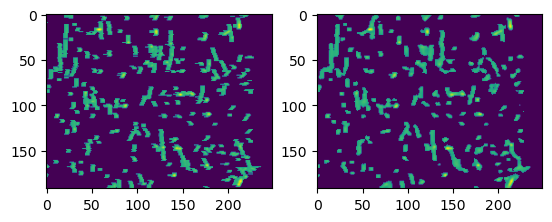

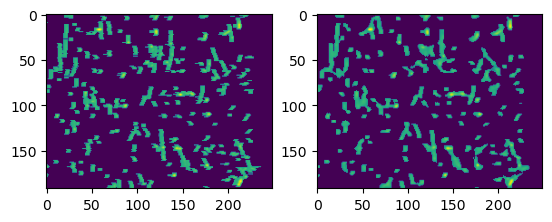

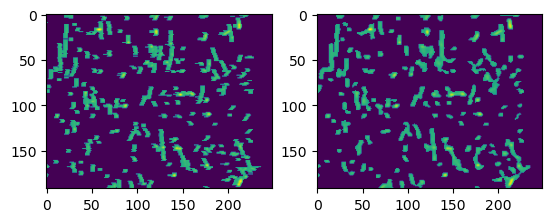

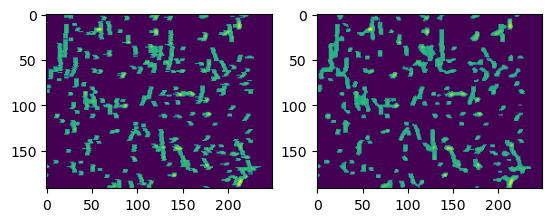

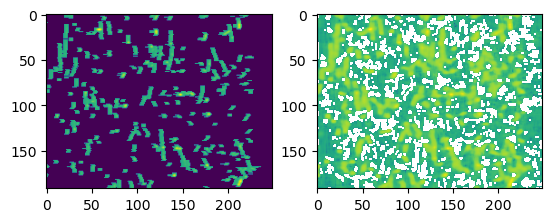

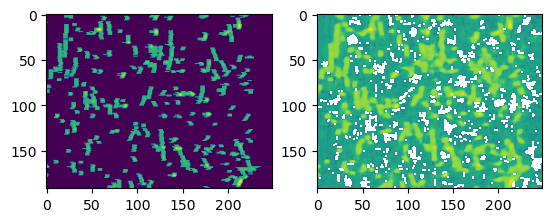

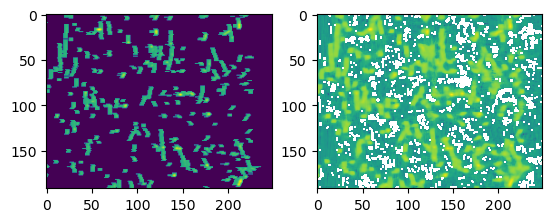

In [77]:
layer = 3
root = Path('/home/yhuang2/PROJs/rtid/rtid/ae2d/')
checkpoints = list(root.rglob('checkpoints*'))
for i, checkpoint in enumerate(checkpoints):
    model_type = str(checkpoint.parents[0]).split('/')[-1]
    print(checkpoint.stem)
    sample_fname = checkpoint/'sample.npz'
    sample = np.load(sample_fname)
    raw = sample['raw']
    rec = sample['rec']
    raw = np.log2(raw + 1)
    rec = np.log2(rec + 1)
    raw_layer = raw[layer]
    rec_layer = rec[layer]

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(raw_layer)
    axes[1].imshow(rec_layer)